In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0 = ALL, 1 = WARNING, 2 = ERROR, 3 = FATAL

# Global params

In [2]:
accepted_categories = ["dress", "high_heel", "handbag", "skirt", "outerwear", "boot"]
label2id = {
    "dress": 0,
    "high_heel": 1, 
    "handbag": 2,
    "skirt": 3, 
    "outerwear": 4, 
    "boot": 5
    
}
id2label = {
    0: "dress",
    1: "high_heel", 
    2: "handbag",
    3: "skirt", 
    4: "outerwear", 
    5: "boot"
}

RANDOM_STATE = 12345

# functions

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image

def plot_random_images_per_category(df, image_column='path', category_column='global_category', max_per_row=4):
    """
    Plot one random image per category from the dataframe.

    Parameters:
    - df: pandas.DataFrame with image paths and categories.
    - image_column: str, column name with image file paths.
    - category_column: str, column name with image categories.
    - max_per_row: int, number of images per row in the plot grid.
    """
    categories = df[category_column].unique()
    sampled_rows = df.groupby(category_column).apply(lambda x: x.sample(1)).reset_index(drop=True)

    num_categories = len(categories)
    num_cols = min(max_per_row, num_categories)
    num_rows = (num_categories + num_cols - 1) // num_cols

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(4 * num_cols, 4 * num_rows))
    axes = axes.flatten() if num_categories > 1 else [axes]

    for ax, (_, row) in zip(axes, sampled_rows.iterrows()):
        try:
            image = Image.open(row[image_column])
            ax.imshow(image)
            ax.set_title(f"{row[category_column]}")
            ax.axis('off')
        except Exception as e:
            ax.text(0.5, 0.5, "Error loading image", ha='center')
            ax.set_title(row[category_column])
            ax.axis('off')
            print(f"Failed to load image at {row[image_column]}: {e}")

    # Hide unused subplots
    for ax in axes[len(sampled_rows):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [4]:
import pandas as pd

def balance_dataframe_by_class(df, category_column='global_category', samples_per_class=100, random_state=42):
    """
    Returns a balanced dataframe with at most `samples_per_class` samples per category.
    If a category has fewer than the desired amount, all its samples are included.

    Parameters:
    - df (pd.DataFrame): Original DataFrame with category information.
    - category_column (str): Column name to balance by (e.g., 'global_category').
    - samples_per_class (int): Target number of samples per class.
    - random_state (int): Seed for reproducible sampling.

    Returns:
    - pd.DataFrame: Balanced DataFrame.
    """
    balanced_dfs = []

    for category, group in df.groupby(category_column):
        if len(group) <= samples_per_class:
            balanced_dfs.append(group)
        else:
            balanced_dfs.append(group.sample(n=samples_per_class, random_state=random_state))

    balanced_df = pd.concat(balanced_dfs).reset_index(drop=True)
    return balanced_df


In [5]:
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_and_save_metrics(model, val_ds, id2label, output_folder):
    """
    Evaluates accuracy, top-2, top-3 accuracy, precision, recall, and F1-score.
    Prints the results and saves them to an Excel file.

    Parameters:
    - model: Trained Keras model
    - val_ds: Validation tf.data.Dataset (batched)
    - id2label: Dictionary mapping label IDs to class names
    - output_folder: Folder path to save the Excel file
    """
    y_true = []
    y_pred = []
    y_pred_probs = []

    # Collect predictions
    for images, labels in val_ds:
        probs = model.predict(images, verbose=0)
        preds = tf.argmax(probs, axis=1).numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)
        y_pred_probs.extend(probs)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_pred_probs = np.array(y_pred_probs)

    # Top-k accuracy
    acc = accuracy_score(y_true, y_pred)
    top_2_acc = tf.keras.metrics.top_k_categorical_accuracy(
        tf.one_hot(y_true, depth=len(id2label)), y_pred_probs, k=2
    ).numpy().mean()

    top_3_acc = tf.keras.metrics.top_k_categorical_accuracy(
        tf.one_hot(y_true, depth=len(id2label)), y_pred_probs, k=3
    ).numpy().mean()

    # Class-wise metrics
    precision = precision_score(y_true, y_pred, average=None, zero_division=0)
    recall = recall_score(y_true, y_pred, average=None, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=None, zero_division=0)

    # Print summary
    print(f"\n✅ Accuracy:     {acc:.4f}")
    print(f"🎯 Top-2 Acc:    {top_2_acc:.4f}")
    print(f"🎯 Top-3 Acc:    {top_3_acc:.4f}")
    print("\n📊 Per-class metrics:\n")

    rows = []
    for idx, class_name in id2label.items():
        row = {
            "class_id": idx,
            "class_name": class_name,
            "precision": precision[idx],
            "recall": recall[idx],
            "f1_score": f1[idx]
        }
        print(f"{class_name:15}  Precision: {precision[idx]:.4f}  Recall: {recall[idx]:.4f}  F1: {f1[idx]:.4f}")
        rows.append(row)

    # Save to Excel
    df_metrics = pd.DataFrame(rows)
    os.makedirs(output_folder, exist_ok=True)
    output_path = os.path.join(output_folder, "classification_report.xlsx")
    df_metrics.to_excel(output_path, index=False)
    print(f"\n📁 Report saved to: {output_path}")


2025-05-18 19:50:52.896601: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747590652.908264   17898 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747590652.912032   17898 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747590652.921694   17898 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747590652.921704   17898 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747590652.921706   17898 computation_placer.cc:177] computation placer alr

# Loading dataframes

In [6]:
import pandas as pd

train_dataframe = balance_dataframe_by_class(pd.read_csv("conf/train.csv"), samples_per_class=600, random_state=RANDOM_STATE)
validation_dataframe = balance_dataframe_by_class(pd.read_csv("conf/validation.csv"), samples_per_class=100, random_state=RANDOM_STATE)

In [7]:
plot_random_images_per_category(train_dataframe)

/tmp/ipykernel_17898/636648337.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_rows = df.groupby(category_column).apply(lambda x: x.sample(1)).reset_index(drop=True)


/tmp/ipykernel_17898/636648337.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_rows = df.groupby(category_column).apply(lambda x: x.sample(1)).reset_index(drop=True)


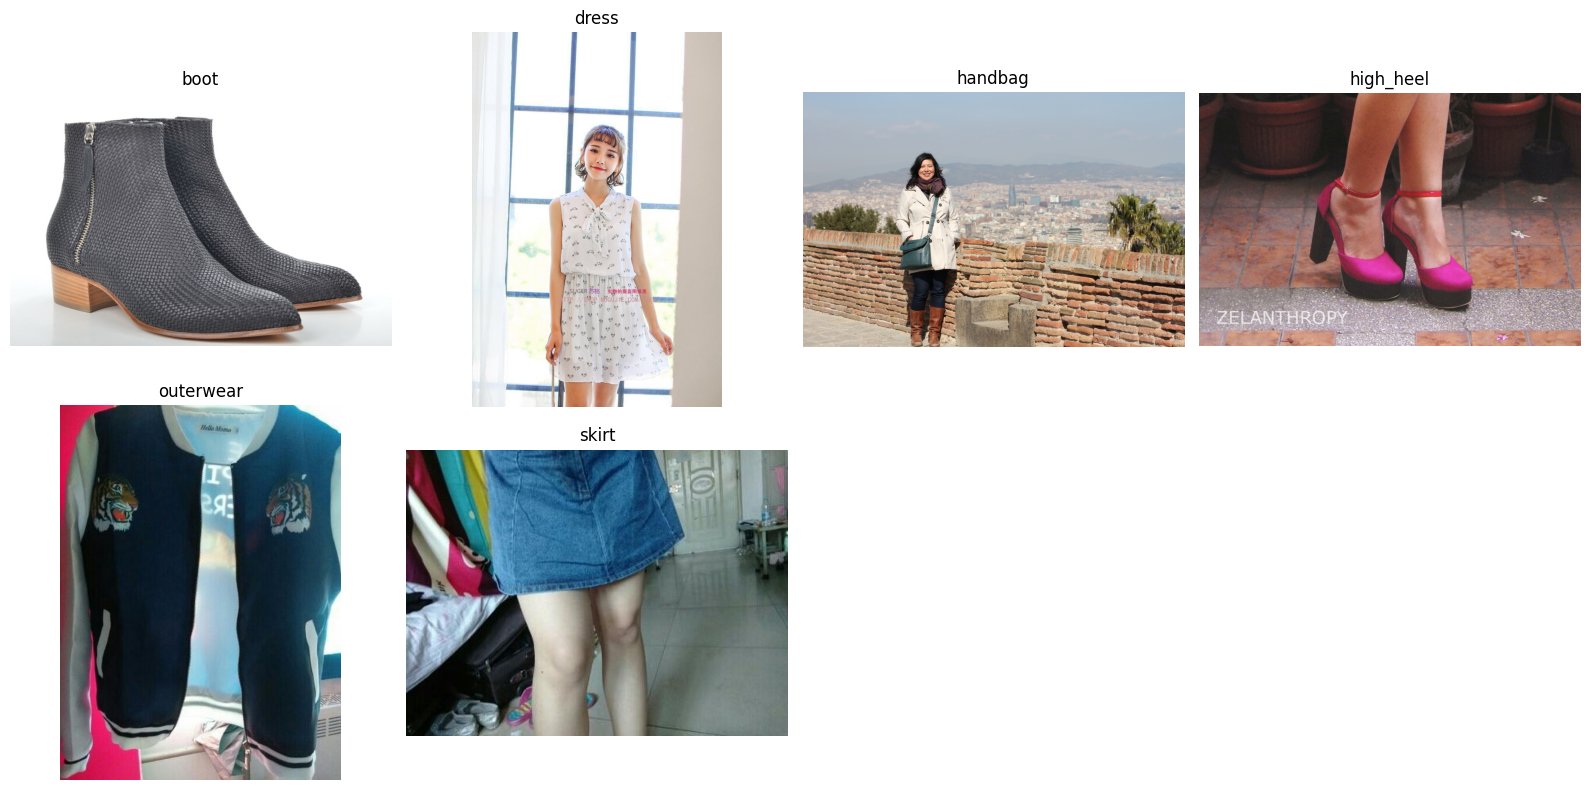

In [8]:
plot_random_images_per_category(validation_dataframe)

In [9]:
train_dataframe.groupby("global_category").size()

global_category
boot         400
dress        600
handbag      400
high_heel    400
outerwear    600
skirt        600
dtype: int64

In [10]:
validation_dataframe.groupby("label_id").size()

label_id
0    100
1    100
2    100
3    100
4    100
5    100
dtype: int64

In [11]:
train_dataframe.head(3)

path global_category  label_id
0  ../custom_dataset/train/Labeled/Boot/ad595795f...            boot         5
1  ../custom_dataset/train/Labeled/Boot/b093b5711...            boot         5
2  ../custom_dataset/train/Labeled/Boot/2fb6778de...            boot         5

# General process

# pre-processing

In [12]:
import tensorflow as tf

IMG_SIZE = 248
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def decode_image(filename, label):
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = image / 255.0  # Normalizar
    return image, label

def prepare_dataset(df, shuffle=True):
    paths = df["path"].values
    labels = df["label_id"].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_image, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=20_000)  # optimize memory
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    #ds = ds.repeat()
    ds = ds.apply(tf.data.experimental.ignore_errors())
    return ds

train_ds = prepare_dataset(train_dataframe)
val_ds = prepare_dataset(validation_dataframe, shuffle=True)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


I0000 00:00:1747590656.576320   17898 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9536 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:0a:00.0, compute capability: 8.6


# Training

In [13]:
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras import layers, models

def sparse_top_k_categorical_accuracy(y_true, y_pred, k=4):
    # Convierte etiquetas de enteros a one-hot para que funcione con top_k
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    return top_k_categorical_accuracy(y_true, y_pred, k=k)

## Mobilenet

In [14]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.metrics import top_k_categorical_accuracy


top_2_accuracy = lambda y_true, y_pred: sparse_top_k_categorical_accuracy(y_true, y_pred, k=2)
top_3_accuracy = lambda y_true, y_pred: sparse_top_k_categorical_accuracy(y_true, y_pred, k=3)

model_mobile = MobileNet(include_top=True, weights=None, input_shape=(IMG_SIZE, IMG_SIZE, 3), classes=len(accepted_categories))
model_mobile.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy",top_2_accuracy,top_3_accuracy]
)

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.callbacks import TensorBoard
import datetime


checkpoint_cb = ModelCheckpoint(
    filepath='models/from_zero_mobile_net/best_model.h5',             # O .keras para el nuevo formato
    monitor='val_accuracy',               # Métrica que decides monitorear
    save_best_only=True,                  # Guarda solo el mejor modelo
    mode='max',                           # Porque estás maximizando
    verbose=1
)

log_dir = "logs/fit/from_zero_mobile_net/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_cb = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,            # Si quieres histogramas de activaciones
    write_graph=True,            # Guarda el grafo del modelo
    write_images=True            # Guarda imágenes de pesos y outputs (opcional)
)

early_stop_cb = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

In [16]:
history = model_mobile.fit(
    train_ds,
    validation_data=val_ds,
    epochs=500,
    callbacks=[early_stop_cb,  checkpoint_cb, tensorboard_cb]
)

/home/carlos/miniconda3/envs/deeplearning_kernel/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:145: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: top_2_accuracy = lambda y_true, y_pred: sparse_top_k_categorical_accuracy(y_true, y_pred, k=2)

  config_arr = [serialize_keras_object(x) for x in obj]
/home/carlos/miniconda3/envs/deeplearning_kernel/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:145: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: top_3_accuracy

Epoch 1/500


I0000 00:00:1747590665.879948   17979 service.cc:152] XLA service 0x7f5f80148390 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1747590665.879978   17979 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Ti, Compute Capability 8.6
I0000 00:00:1747590667.039270   17979 cuda_dnn.cc:529] Loaded cuDNN version 90300
2025-05-18 19:51:08.351402: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-18 19:51:08.484386: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-18 19:51:08.615616: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal

      1/Unknown 19s 19s/step - accuracy: 0.2188 - lambda: 0.3125 - lambda_1: 0.4688 - loss: 2.0727

I0000 00:00:1747590676.231105   17979 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


     92/Unknown 22s 42ms/step - accuracy: 0.2447 - lambda: 0.4453 - lambda_1: 0.6014 - loss: 1.7875

2025-05-18 19:51:22.000154: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-18 19:51:22.129549: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-18 19:51:22.258656: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-05-18 19:51:22.388866: E external/local_xla/xla/stream_executor/cuda/cuda_timer.cc:86] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


     94/Unknown 32s 143ms/step - accuracy: 0.2451 - lambda: 0.4460 - lambda_1: 0.6023 - loss: 1.7860

/home/carlos/miniconda3/envs/deeplearning_kernel/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.16667, saving model to models/from_zero_mobile_net/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 37s 199ms/step - accuracy: 0.2452 - lambda: 0.4464 - lambda_1: 0.6027 - loss: 1.7853 - val_accuracy: 0.1667 - val_lambda: 0.3333 - val_lambda_1: 0.5000 - val_loss: 1.8630
Epoch 2/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3085 - lambda: 0.5529 - lambda_1: 0.7107 - loss: 1.6174
Epoch 2: val_accuracy did not improve from 0.16667
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - accuracy: 0.3085 - lambda: 0.5531 - lambda_1: 0.7110 - loss: 1.6173 - val_accuracy: 0.1667 - val_lambda: 0.3333 - val_lambda_1: 0.5000 - val_loss: 2.1088
Epoch 3/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3685 - lambda: 0.6075 - lambda_1: 0.7687 - loss: 1.5308
Epoch 3: val_accuracy did not improve from 0.16667
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.3683 - lambda: 0.6074 - lambda_1: 0.7687 - loss: 1.5309 - val_accuracy: 0.1667 - val_lambda: 0.3333 - val_lambda_1: 0.5000 - val_loss: 2.4930
Epoch 4/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 69ms/step - accuracy: 0.4698 - lambda: 0.7103 - lambda_1: 0.8465 - loss: 1.3257 - val_accuracy: 0.1867 - val_lambda: 0.3333 - val_lambda_1: 0.4933 - val_loss: 2.9175
Epoch 8/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5093 - lambda: 0.7497 - lambda_1: 0.8814 - loss: 1.2353
Epoch 8: val_accuracy improved from 0.18667 to 0.23167, saving model to models/from_zero_mobile_net/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 68ms/step - accuracy: 0.5093 - lambda: 0.7497 - lambda_1: 0.8813 - loss: 1.2355 - val_accuracy: 0.2317 - val_lambda: 0.3333 - val_lambda_1: 0.4850 - val_loss: 3.2763
Epoch 9/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5487 - lambda: 0.7722 - lambda_1: 0.8958 - loss: 1.1637
Epoch 9: val_accuracy improved from 0.23167 to 0.30333, saving model to models/from_zero_mobile_net/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.5485 - lambda: 0.7721 - lambda_1: 0.8956 - loss: 1.1642 - val_accuracy: 0.3033 - val_lambda: 0.4850 - val_lambda_1: 0.6383 - val_loss: 2.0310
Epoch 10/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5776 - lambda: 0.7897 - lambda_1: 0.9005 - loss: 1.1102
Epoch 10: val_accuracy improved from 0.30333 to 0.36500, saving model to models/from_zero_mobile_net/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.5773 - lambda: 0.7895 - lambda_1: 0.9006 - loss: 1.1102 - val_accuracy: 0.3650 - val_lambda: 0.6033 - val_lambda_1: 0.7667 - val_loss: 1.9052
Epoch 11/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6094 - lambda: 0.8277 - lambda_1: 0.9271 - loss: 0.9953
Epoch 11: val_accuracy did not improve from 0.36500
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.6092 - lambda: 0.8277 - lambda_1: 0.9271 - loss: 0.9956 - val_accuracy: 0.3500 - val_lambda: 0.5933 - val_lambda_1: 0.7550 - val_loss: 1.8265
Epoch 12/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6356 - lambda: 0.8422 - lambda_1: 0.9395 - loss: 0.9432
Epoch 12: val_accuracy improved from 0.36500 to 0.39333, saving model to models/from_zero_mobile_net/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.6356 - lambda: 0.8421 - lambda_1: 0.9395 - loss: 0.9432 - val_accuracy: 0.3933 - val_lambda: 0.5983 - val_lambda_1: 0.7467 - val_loss: 2.0871
Epoch 13/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6756 - lambda: 0.8592 - lambda_1: 0.9375 - loss: 0.8576
Epoch 13: val_accuracy did not improve from 0.39333
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.6752 - lambda: 0.8590 - lambda_1: 0.9375 - loss: 0.8583 - val_accuracy: 0.3450 - val_lambda: 0.5533 - val_lambda_1: 0.7317 - val_loss: 2.7138
Epoch 14/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6909 - lambda: 0.8869 - lambda_1: 0.9526 - loss: 0.8090
Epoch 14: val_accuracy did not improve from 0.39333
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - accuracy: 0.6909 - lambda: 0.8869 - lambda_1: 0.9526 - loss: 0.8088 - val_accuracy: 0.3117 - val_lambda: 0.5233 - val_lambda_1: 0.7050 - val_loss: 3.4874
Epoch 15/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accurac

94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 70ms/step - accuracy: 0.8720 - lambda: 0.9648 - lambda_1: 0.9863 - loss: 0.3799 - val_accuracy: 0.4033 - val_lambda: 0.6117 - val_lambda_1: 0.7767 - val_loss: 2.5267
Epoch 23/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8885 - lambda: 0.9737 - lambda_1: 0.9910 - loss: 0.3334
Epoch 23: val_accuracy did not improve from 0.40333
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 65ms/step - accuracy: 0.8882 - lambda: 0.9736 - lambda_1: 0.9909 - loss: 0.3341 - val_accuracy: 0.3500 - val_lambda: 0.5733 - val_lambda_1: 0.7500 - val_loss: 3.0405
Epoch 24/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.8651 - lambda: 0.9666 - lambda_1: 0.9878 - loss: 0.3735
Epoch 24: val_accuracy did not improve from 0.40333
94/94 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - accuracy: 0.8651 - lambda: 0.9666 - lambda_1: 0.9878 - loss: 0.3735 - val_accuracy: 0.3733 - val_lambda: 0.5967 - val_lambda_1: 0.7483 - val_loss: 3.0619
Epoch 25/500
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accurac

### Testing it

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

def plot_top3_predictions(model, val_ds, id2label, rows=3, cols=8):
    """
    Muestra imágenes con las Top-3 predicciones de un modelo, coloreando en verde
    si la etiqueta verdadera está entre ellas, y rojo en caso contrario.

    Parameters:
    - model: modelo Keras o TensorFlow.
    - val_ds: dataset iterable (como tf.data.Dataset).
    - id2label: diccionario {id: nombre_clase}.
    - rows: número de filas a mostrar.
    - cols: número de columnas a mostrar.
    """
    val_images, val_labels = next(iter(val_ds))
    pred_probs = model.predict(val_images)
    
    top3_pred_indices = tf.math.top_k(pred_probs, k=3).indices.numpy()

    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    fig.suptitle("Top-3 Predicciones del modelo", fontsize=16)

    for i, ax in enumerate(axes.flat):
        if i >= len(val_images):
            break

        image = val_images[i].numpy()
        true_label = int(val_labels[i].numpy())
        top3_labels = top3_pred_indices[i]

        top3_names = [id2label[idx] for idx in top3_labels]
        pred_text = "\n".join([f"{j+1}: {name}" for j, name in enumerate(top3_names)])

        color = "green" if true_label in top3_labels else "red"

        ax.imshow(image)
        ax.set_title(f"{pred_text}\nT: {id2label[true_label]}", color=color, fontsize=10)
        ax.axis("off")

    plt.tight_layout()
    plt.subplots_adjust(top=0.88)
    plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


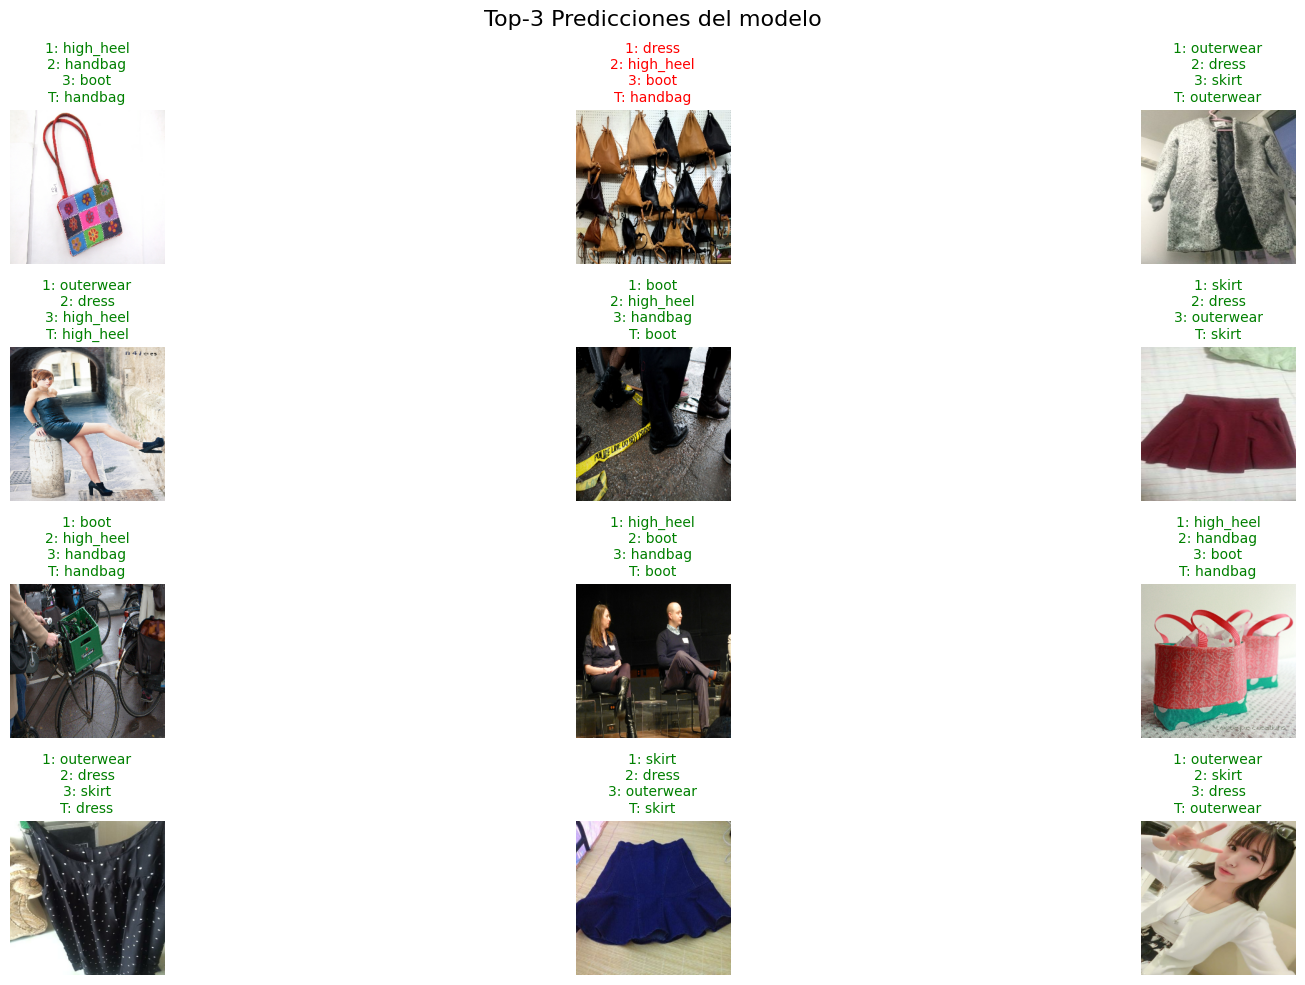

In [18]:
plot_top3_predictions(model_mobile, val_ds, id2label, rows=4, cols=3)

In [23]:
evaluate_and_save_metrics(model_mobile, val_ds, id2label, output_folder="./models/from_zero_mobile_net/")


✅ Accuracy:     0.3500
🎯 Top-2 Acc:    0.5933
🎯 Top-3 Acc:    0.7550

📊 Per-class metrics:

dress            Precision: 0.3398  Recall: 0.3500  F1: 0.3448
high_heel        Precision: 0.2190  Recall: 0.3000  F1: 0.2532
handbag          Precision: 0.4286  Recall: 0.1500  F1: 0.2222
skirt            Precision: 0.7705  Recall: 0.4700  F1: 0.5839
outerwear        Precision: 0.3232  Recall: 0.6400  F1: 0.4295
boot             Precision: 0.2879  Recall: 0.1900  F1: 0.2289

📁 Report saved to: ./models/from_zero_mobile_net/classification_report.xlsx


# Performance plot

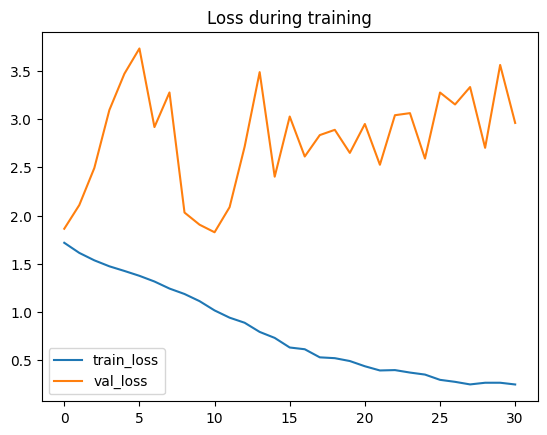

In [24]:
import matplotlib.pyplot as plt

plt.title("Loss during training")
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

## Efficient

In [25]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.metrics import top_k_categorical_accuracy

# Función de métrica personalizada para sparse top-k
def sparse_top_k_categorical_accuracy(y_true, y_pred, k=4):
    y_true = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[-1])
    return top_k_categorical_accuracy(y_true, y_pred, k=k)

# Definir top-2 y top-3
top_2_accuracy = lambda y_true, y_pred: sparse_top_k_categorical_accuracy(y_true, y_pred, k=2)
top_3_accuracy = lambda y_true, y_pred: sparse_top_k_categorical_accuracy(y_true, y_pred, k=3)

# Crear el modelo EfficientNetV2B0
model_effnet = EfficientNetV2B0(
    include_top=True,
    weights=None,
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    classes=len(accepted_categories)
)

# Compilar el modelo
model_effnet.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy", top_2_accuracy, top_3_accuracy]
)


In [26]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from tensorflow.keras.callbacks import TensorBoard
import datetime


checkpoint_cb = ModelCheckpoint(
    filepath='models/from_zero_efficient_net/best_model.h5',             # O .keras para el nuevo formato
    monitor='val_accuracy',               # Métrica que decides monitorear
    save_best_only=True,                  # Guarda solo el mejor modelo
    mode='max',                           # Porque estás maximizando
    verbose=1
)

log_dir = "logs/fit/from_zero_efficient_net/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

tensorboard_cb = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,            # Si quieres histogramas de activaciones
    write_graph=True,            # Guarda el grafo del modelo
    write_images=True            # Guarda imágenes de pesos y outputs (opcional)
)

early_stop_cb = EarlyStopping(
    monitor='val_loss',
    patience=20,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

In [27]:
history_efficient = model_effnet.fit(
    train_ds,
    validation_data=val_ds,
    epochs=500,
    callbacks=[early_stop_cb,  checkpoint_cb, tensorboard_cb]
)

Epoch 1/500


/home/carlos/miniconda3/envs/deeplearning_kernel/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:145: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: top_2_accuracy = lambda y_true, y_pred: sparse_top_k_categorical_accuracy(y_true, y_pred, k=2)

  config_arr = [serialize_keras_object(x) for x in obj]
/home/carlos/miniconda3/envs/deeplearning_kernel/lib/python3.10/site-packages/keras/src/saving/serialization_lib.py:145: UserWarning: The object being serialized includes a `lambda`. This is unsafe. In order to reload the object, you will have to pass `safe_mode=False` to the loading function. Please avoid using `lambda` in the future, and use named Python functions instead. This is the `lambda` being serialized: top_3_accuracy

     94/Unknown 81s 335ms/step - accuracy: 0.1627 - lambda: 0.3367 - lambda_1: 0.5153 - loss: 2.5182

/home/carlos/miniconda3/envs/deeplearning_kernel/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 1: val_accuracy improved from -inf to 0.16833, saving model to models/from_zero_efficient_net/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 94s 475ms/step - accuracy: 0.1628 - lambda: 0.3369 - lambda_1: 0.5153 - loss: 2.5168 - val_accuracy: 0.1683 - val_lambda: 0.3200 - val_lambda_1: 0.5083 - val_loss: 1.8542
Epoch 2/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1829 - lambda: 0.3571 - lambda_1: 0.5386 - loss: 2.2078
Epoch 2: val_accuracy did not improve from 0.16833
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 96ms/step - accuracy: 0.1828 - lambda: 0.3569 - lambda_1: 0.5383 - loss: 2.2080 - val_accuracy: 0.1667 - val_lambda: 0.3467 - val_lambda_1: 0.5000 - val_loss: 5.7992
Epoch 3/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1966 - lambda: 0.3782 - lambda_1: 0.5401 - loss: 2.1783
Epoch 3: val_accuracy did not improve from 0.16833
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step - accuracy: 0.1967 - lambda: 0.3781 - lambda_1: 0.5401 - loss: 2.1781 - val_accuracy: 0.1417 - val_lambda: 0.3050 - val_lambda_1: 0.4900 - val_loss: 1.9208
Epoch 4/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy

94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.1995 - lambda: 0.3717 - lambda_1: 0.5524 - loss: 2.2180 - val_accuracy: 0.1767 - val_lambda: 0.3783 - val_lambda_1: 0.6167 - val_loss: 108.2531
Epoch 6/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2185 - lambda: 0.4210 - lambda_1: 0.5868 - loss: 2.0959
Epoch 6: val_accuracy did not improve from 0.17667
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.2185 - lambda: 0.4211 - lambda_1: 0.5869 - loss: 2.0956 - val_accuracy: 0.1683 - val_lambda: 0.3300 - val_lambda_1: 0.4900 - val_loss: 2.0080
Epoch 7/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2219 - lambda: 0.4074 - lambda_1: 0.5629 - loss: 2.0576
Epoch 7: val_accuracy improved from 0.17667 to 0.18333, saving model to models/from_zero_efficient_net/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 104ms/step - accuracy: 0.2221 - lambda: 0.4074 - lambda_1: 0.5630 - loss: 2.0575 - val_accuracy: 0.1833 - val_lambda: 0.3600 - val_lambda_1: 0.5267 - val_loss: 2.2641
Epoch 8/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2518 - lambda: 0.4564 - lambda_1: 0.6050 - loss: 1.9363
Epoch 8: val_accuracy improved from 0.18333 to 0.26167, saving model to models/from_zero_efficient_net/best_model.h5


94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 108ms/step - accuracy: 0.2518 - lambda: 0.4560 - lambda_1: 0.6048 - loss: 1.9366 - val_accuracy: 0.2617 - val_lambda: 0.3933 - val_lambda_1: 0.5867 - val_loss: 1.7511
Epoch 9/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2505 - lambda: 0.4489 - lambda_1: 0.6050 - loss: 1.8814
Epoch 9: val_accuracy did not improve from 0.26167
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 99ms/step - accuracy: 0.2504 - lambda: 0.4490 - lambda_1: 0.6052 - loss: 1.8815 - val_accuracy: 0.1533 - val_lambda: 0.5133 - val_lambda_1: 0.7800 - val_loss: 168.4704
Epoch 10/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2586 - lambda: 0.4714 - lambda_1: 0.6396 - loss: 1.8610
Epoch 10: val_accuracy did not improve from 0.26167
94/94 ━━━━━━━━━━━━━━━━━━━━ 11s 95ms/step - accuracy: 0.2586 - lambda: 0.4714 - lambda_1: 0.6398 - loss: 1.8607 - val_accuracy: 0.1717 - val_lambda: 0.3283 - val_lambda_1: 0.4850 - val_loss: 2.1445
Epoch 11/500
93/94 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - acc

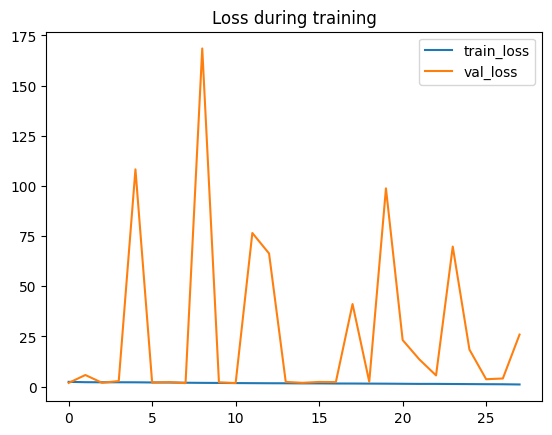

In [28]:
import matplotlib.pyplot as plt

plt.title("Loss during training")
plt.plot(history_efficient.history['loss'], label='train_loss')
plt.plot(history_efficient.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


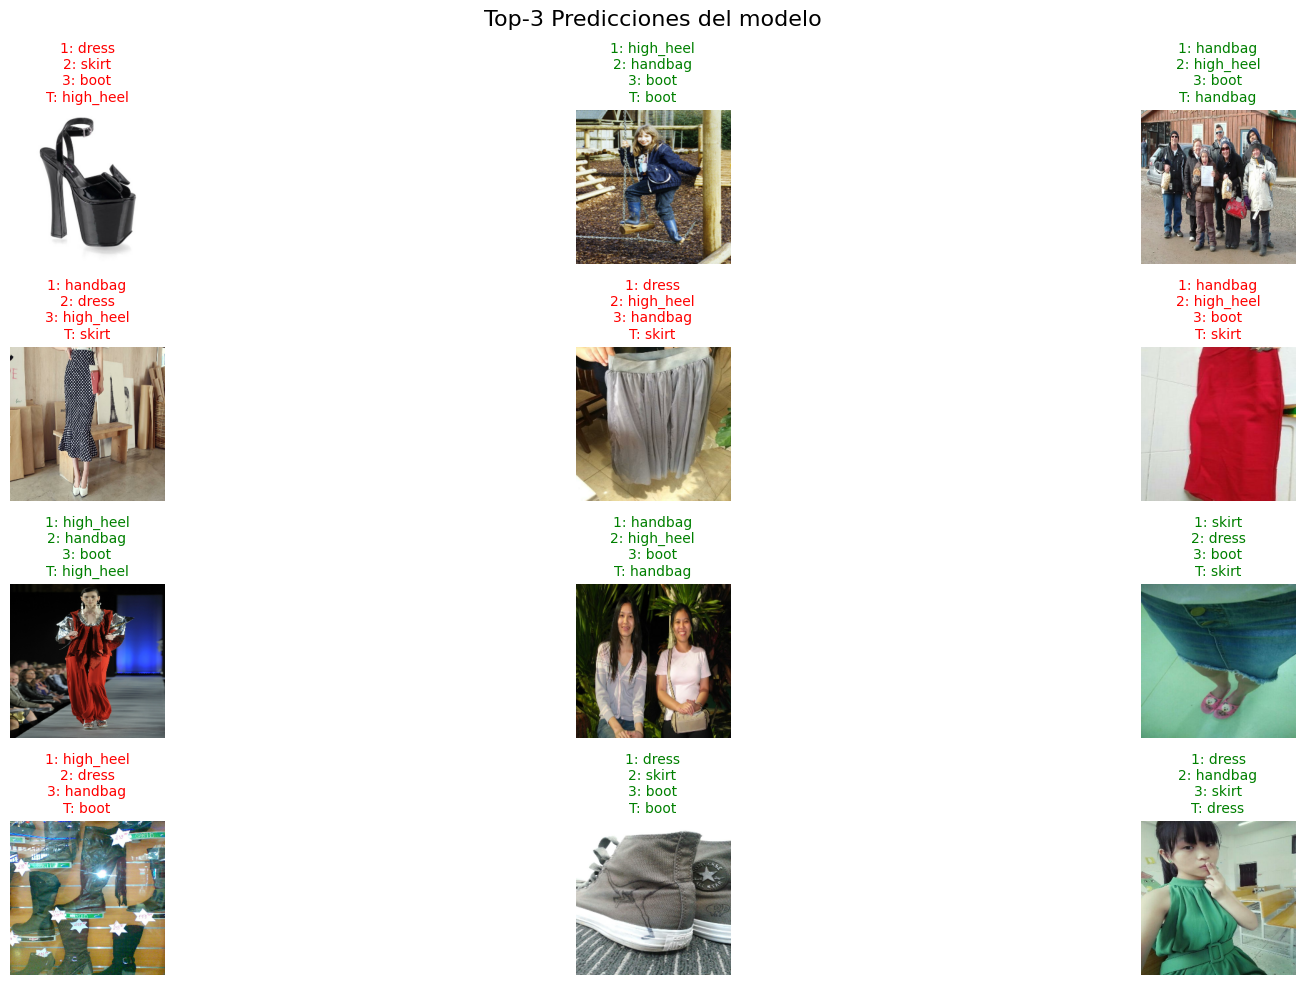

In [29]:
plot_top3_predictions(model_effnet, val_ds, id2label, rows=4, cols=3)

In [30]:
evaluate_and_save_metrics(model_effnet, val_ds, id2label, output_folder="./models/from_zero_efficient_net/")


✅ Accuracy:     0.2617
🎯 Top-2 Acc:    0.3933
🎯 Top-3 Acc:    0.5850

📊 Per-class metrics:

dress            Precision: 0.2470  Recall: 0.6100  F1: 0.3516
high_heel        Precision: 0.1765  Recall: 0.1800  F1: 0.1782
handbag          Precision: 0.2611  Recall: 0.4700  F1: 0.3357
skirt            Precision: 0.5000  Recall: 0.3100  F1: 0.3827
outerwear        Precision: 0.0000  Recall: 0.0000  F1: 0.0000
boot             Precision: 0.0000  Recall: 0.0000  F1: 0.0000

📁 Report saved to: ./models/from_zero_efficient_net/classification_report.xlsx
